In [6]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

In [7]:
dataset_mean = [0.48011, 0.47254, 0.52592]
dataset_std = [0.20765, 0.21533, 0.20043]

In [11]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
       # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        # Second convolutional block
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        # Dense layers
        # If input images are 32x32, after two poolings (factor of 4 reduction), spatial size becomes 8x8.
        self.flatten_dim = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # First block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        # Second block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [ ]:
# def live_test_video(model_path):
#     # Load model
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = TrafficSignCNN(num_classes=12).to(device)
#     model.load_state_dict(torch.load(model_path, map_location=device))
#     model.eval()
    
#     # Transformations (must match training)
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((32, 32)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=dataset_mean, std=dataset_std)
#     ])
    
#     cap = cv2.VideoCapture(0)
#     if not cap.isOpened():
#         print("Error: Could not open webcam")
#         return
    
#     try:
#         while True:
#             ret, frame = cap.read()
#             if not ret:
#                 print("Error: Couldn't read frame")
#                 break
                
#             # Process frame
#             rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             tensor_img = transform(rgb).unsqueeze(0).to(device)
            
#             # Inference
#             with torch.no_grad():
#                 outputs = model(tensor_img)
#                 _, pred = torch.max(outputs, 1)
#                 sign_name = class_names[pred.item()]
            
#             # Display option 1: Save to file (works everywhere)
#             output_frame = frame.copy()
#             cv2.putText(output_frame, sign_name, (10, 30),
#                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
#             cv2.imwrite('latest_detection.jpg', output_frame)
            
#             # Display option 2: For Jupyter notebooks
#             try:
#                 from IPython.display import Image, clear_output, display
#                 _, buffer = cv2.imencode('.jpg', output_frame)
#                 display(Image(data=buffer.tobytes()))
#                 clear_output(wait=True)
#             except ImportError:
#                 pass
            
#             # Exit condition (no need for waitKey)
#             # Press 'q' in terminal/notebook to stop
#             # Or implement your own stopping condition
            
#     except KeyboardInterrupt:
#         print("Stopping...")
#     finally:
#         cap.release()
#         print("Webcam released")

In [ ]:
# live_test_video("best_model.pth")

In [12]:
def live_test_image(model_path, test_path):
    # Load model on the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12).to(device)
    # Remove unsupported arguments: weights_only, mmap
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Define the transformation pipeline using Albumentations
    transform_simple = A.Compose(
        [
            A.Resize(32, 32),
            A.Normalize(mean=tuple(dataset_mean), std=tuple(dataset_std)),
            ToTensorV2()
        ],
        p=1
    )
    
    # Define class names
    class_names = [
        'barred_area',
        'cross_walk',
        'go_straight',
        'no_passing_zone_beginning',
        'parking_zone',
        'priority_over',
        'steep_hill_downhill',
        'steep_hill_uphill',
        'stop',
        'tunnel_beginning',
        'turn_left',
        'turn_right'
    ]
    
    # Get image paths from test_path (either directory or a single file)
    if os.path.isdir(test_path):
        image_paths = [os.path.join(test_path, f) for f in os.listdir(test_path) 
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    elif os.path.isfile(test_path):
        image_paths = [test_path]
    else:
        raise ValueError(f"Path {test_path} does not exist")
    
    if not image_paths:
        print("No images found to process")
        return
    
    predictions = []
    for img_path in image_paths:
        image = cv2.imread(img_path)
        if image is None:
            print(f"Could not read {img_path}")
            continue
            
        # Convert image from BGR to RGB
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        transformed = transform_simple(image=rgb)
        input_tensor = transformed["image"].unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            confidence, pred = torch.max(probabilities, 1)
            confidence = confidence.item()
        
        predictions.append({
            'path': img_path,
            'image': rgb,
            'class_idx': pred.item(),
            'confidence': confidence
        })
    
    # Display the predictions on a grid
    plot_predictions(predictions, class_names)

def plot_predictions(predictions, class_names, cols=4):
    plt.figure(figsize=(20, 10))
    rows = (len(predictions) + cols - 1) // cols
    
    for i, pred in enumerate(predictions, 1):
        plt.subplot(rows, cols, i)
        plt.imshow(pred['image'])
        plt.title(f"{class_names[pred['class_idx']]}\n({pred['confidence']:.1%})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

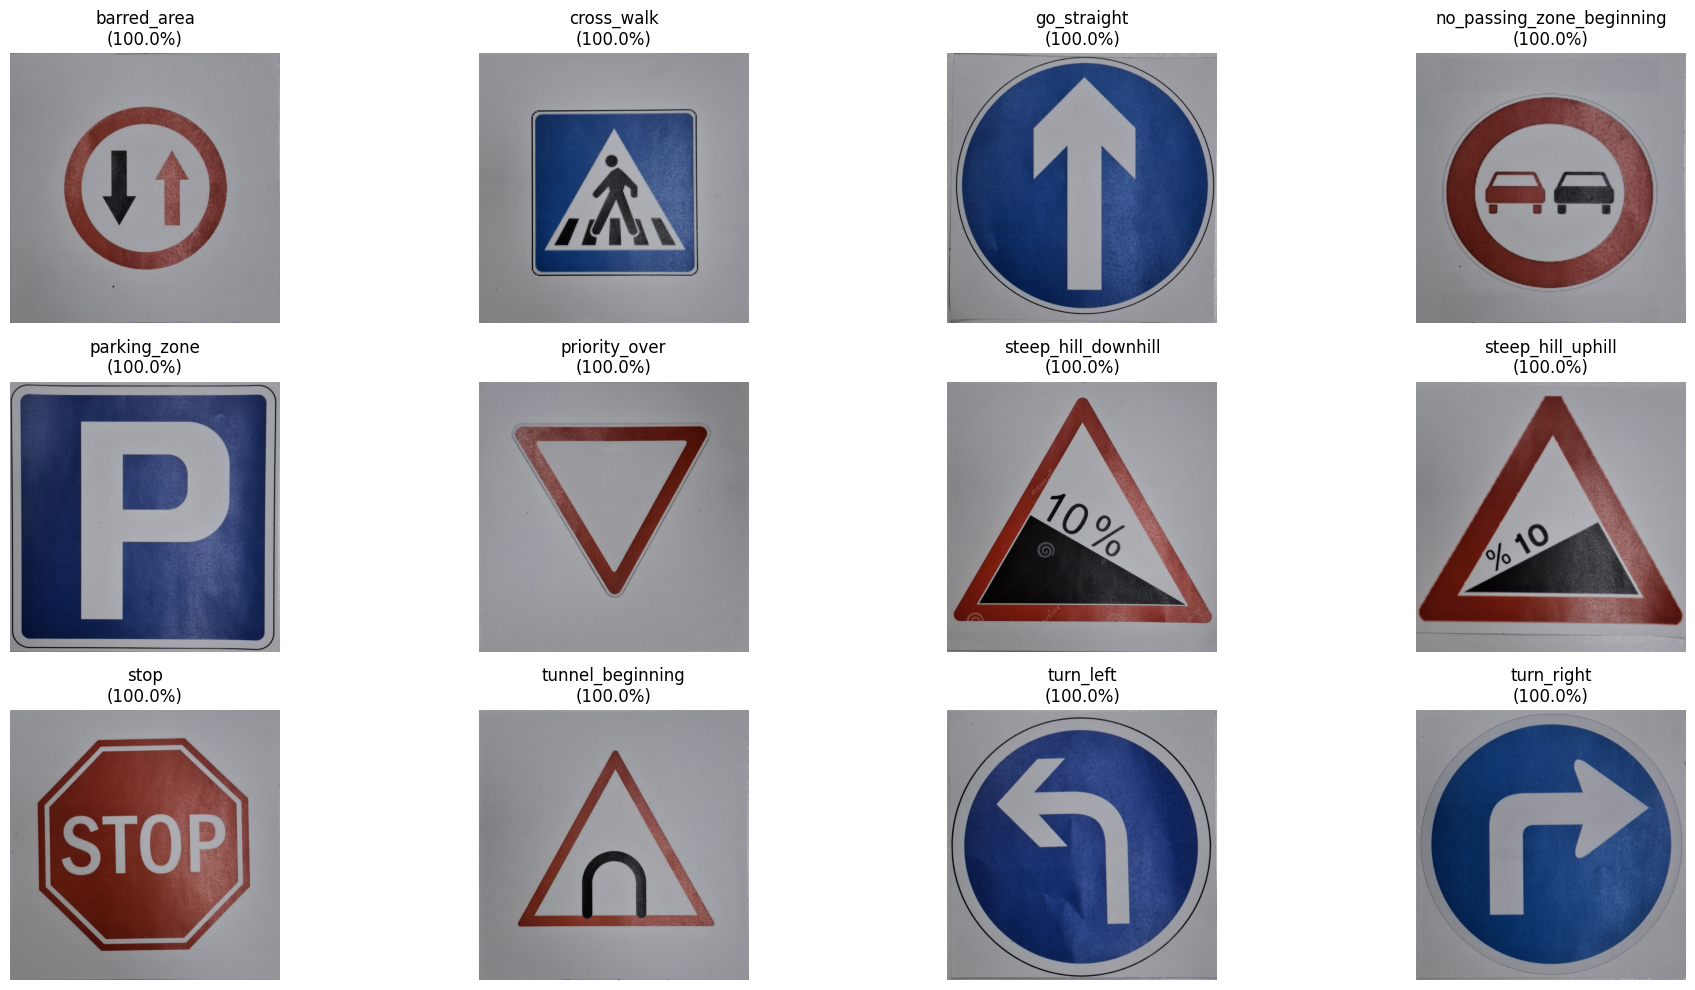

In [13]:
model_path = "TrainedModels/traffic_sign_cnn_V03.pth"
test_path = "Dataset/Mask"

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

live_test_image(model_path, test_path)